In [1]:
import math
import sys
import numpy as np
from scipy.integrate import simps
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter
from six.moves import cPickle as pickle
from scipy.spatial.distance import cosine
import os

In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})


In [3]:
# Helper functions
def unpickle_data(pickle_file):
    """
    Unpickles the data from a pickle file
    """
    f = open(pickle_file, 'rb')
    return pickle.load(f)

def populate_data_dict(data_dict, key, pickle_file):
    """
    Given a key populates a dictionary
    """
    data_dict[key] = unpickle_data(pickle_file)
    
    
def populate_k_shot_acc_dict(data_dict, key, k_shot_dict):
    num_runs = data_dict[key]['mean'].shape[0]
    k_shot_dict[key] = []
    for run in range(num_runs):
        key_acc = data_dict[key]['mean'][run]
        num_batches = key_acc.shape[1]
        num_tasks = key_acc.shape[0]
        k_shot_acc = np.zeros([num_batches], dtype=np.float32)
        for i in range(num_batches):
            acc = 0.0
            for j in range(num_tasks):
                acc += key_acc[j,i]
            k_shot_acc[i] = acc/ num_tasks
        
        k_shot_dict[key].append(k_shot_acc)
        
    k_shot_dict[key] = np.array(k_shot_dict[key])

In [16]:
def plot_average_accuracy_along_training_path(data_mean, plot_name=None, is_cifar=False):
    """
    Plot the average accuracy along the training path
    """
    plt.clf()
    K_FOR_CROSS_VAL = 3
    avg_acc_dict = dict()
    for key in data_mean:
        data = data_mean[key]['mean'].mean(0)
        num_tasks = data.shape[0]
        avg_acc = np.zeros(num_tasks)
        for i in range(num_tasks):
            avg_acc[i] = np.mean(data[i,:i+1])
#             if key == 'MULTI-TASK':
#                 avg_acc[i] = np.mean(data)
#             elif key == 'ICARL':
#                 avg_acc[i] = np.mean(data[i,:i+1])
#             elif key == 'GEM':
#                 avg_acc[i] = np.mean(data[i,:i+1])
                
#             else:
#                 avg_acc[i] = np.mean(data[i,:i+1])
        print(key, avg_acc[-1])
        avg_acc_dict[key] = avg_acc

    
    fig = plt.figure(figsize=(8,2.5))
    ax = fig.add_axes([0.15, 0.21, 0.6, 0.75])
    tasks = np.arange(1, num_tasks+1)
    
    colors = {'STL-p-MNIST':'-k', 'SGD-p-MNIST': 'C0', 'RLL-p-MNIST':'C1', 'STL-r-MNIST':'C2', 'SGD-r-MNIST': 'C3', 'RLL-r-MNIST':'C4'}
#     , 'EWC': '-m', 'PI': '-b', 'MAS': '-y', 
#               'RWALK':'-g', 'PROG-NN':'C5--', 'GEM':'-c', 'A-GEM':'-r', 'MER': 'C6'}
    
        
    for i, key in enumerate(data_mean):
        if key == 'MULTI-TASK':
            continue
        else:
            if 'STL' in key:
                ax.plot(tasks, avg_acc_dict[key],'%s'%(colors[key]), marker='^', markersize=7, lw=2, label=key)
            else:
                ax.plot(tasks, avg_acc_dict[key],'%s'%(colors[key]), lw=2, label=key)
                
#     line, =  ax.plot(tasks, avg_acc_dict['MULTI-TASK'],'%s'%(colors['MULTI-TASK']), lw=2, label='MULTI-TASK')
#     line.set_dashes([2, 2, 10, 2])
        
#     if is_cifar:
#         ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
    ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
    ax.set_xlabel('Tasks', size=20)
    ax.set_ylabel('Avg Accuracy', size=20)
    plt.xticks(tasks)
    plt.grid()

    
    if plot_name is not None:
        plt.savefig(plot_name)
    else:
        plt.show()

In [17]:
def compute_fgt(acc, key):
    num_tasks = acc.shape[0] # Number of tasks
    last_batch_dim = acc.shape[1] - 1 # Last batch dimension
    fgt_msr = np.zeros([num_tasks-1]) # Not defined for first task. Store forgetting after each task
    worst_case_fgt = np.zeros([num_tasks-1]) # Not defined for first task. Store forgetting after each task
    for i in range(num_tasks):
        if i == 0:
            pass
        else:
            wst_fgt_i = []
            fgt_i = 0.0
            for j in range(i):
                if key == 'GEM' or key == 'ICARL':
                    fgt_per_task = np.amax(acc[:i,j]) - acc[i,j]
                else:
                    fgt_per_task = np.amax(acc[:i,last_batch_dim]) - acc[i,last_batch_dim]
                        
                fgt_i += fgt_per_task
                wst_fgt_i.append(fgt_per_task)
            fgt_msr[i-1] = fgt_i/ (j+1)
            wst_fgt_i = np.array(wst_fgt_i)
            worst_case_fgt[i-1] = np.max(wst_fgt_i)
                
    return fgt_msr, worst_case_fgt 


def average_acc_stats_across_runs(data, key):
    """
    Compute the average accuracy statistics (mean and std) across runs
    """
    num_runs = data.shape[0]
    avg_acc = np.zeros(num_runs)
    for i in range(num_runs):
        if key == 'GEM':
            avg_acc[i] = np.mean(data[i][-1])
        else:
            avg_acc[i] = np.mean(data[i][-1, -1])
        
    return avg_acc.mean()*100, avg_acc.std()*100

def average_fgt_stats_across_runs(data, key):
    """
    Compute the forgetting statistics (mean and std) across runs
    """
    num_runs = data.shape[0]
    fgt = np.zeros(num_runs)
    wst_fgt = np.zeros(num_runs)
    for i in range(num_runs):
        fgt_i, wst_fgt_i = compute_fgt(data[i], key)
        #print('{}, {}'.format(i, fgt_i))
        fgt[i] = fgt_i[-1]
        wst_fgt[i] = wst_fgt_i[-1]
        
    return fgt.mean(), fgt.std(), wst_fgt.mean(), wst_fgt.std()

In [18]:


# def populate_k_shot_acc_dict_with_varying_batches(data_dict, key, k_shot_dict):
#     num_runs = data_dict[key]['mean'].shape[0]
#     k_shot_dict[key] = []
#     for run in range(num_runs):
#         key_acc = data_dict[key]['mean'][run]
#         num_tasks = key_acc.shape[0]
#         # First compute the number of batches for each task (as total number of examples per task is different)
#         batches_per_task = []
#         for i in range(num_tasks):
#             batches_per_task.append(np.max(np.nonzero(np.sum(key_acc[i], axis=1))))

#         # Since the code above returned an index, so add '1' to get the count of batches for each task
#         batches_per_task = np.array(batches_per_task) + 1
#         max_batches = np.max(batches_per_task)
#         k_shot_acc = np.zeros([max_batches], dtype=np.float32)
    
#         for i in range(max_batches):
#             acc = 0.0
#             task_count_with_this_batch = 0
#             for j in range(num_tasks):
#                 if i < batches_per_task[j]: # Only add accuracy if current task has that many batches
#                     acc += key_acc[j,i,j]
#                     task_count_with_this_batch += 1
#                 else:
#                     acc += key_acc[j,batches_per_task[j]-1,j]
#             k_shot_acc[i] = acc/ num_tasks
        
#         # Store the average accuracy in the dictionary
#         k_shot_dict[key].append(k_shot_acc)
    
#     k_shot_dict[key] = np.array(k_shot_dict[key])
    
#     return batches_per_task    


# def compute_fgt(acc, key):
#     num_tasks = acc.shape[0] # Number of tasks
#     last_batch_dim = acc.shape[1] - 1 # Last batch dimension
#     fgt_msr = np.zeros([num_tasks-1]) # Not defined for first task. Store forgetting after each task
#     worst_case_fgt = np.zeros([num_tasks-1]) # Not defined for first task. Store forgetting after each task
#     for i in range(num_tasks):
#         if i == 0:
#             pass
#         else:
#             wst_fgt_i = []
#             fgt_i = 0.0
#             for j in range(i):
#                 if key == 'GEM' or key == 'ICARL':
#                     fgt_per_task = np.amax(acc[:i,j]) - acc[i,j]
#                 else:
#                     fgt_per_task = np.amax(acc[:i,last_batch_dim,j]) - acc[i,last_batch_dim]
                        
#                 fgt_i += fgt_per_task
#                 wst_fgt_i.append(fgt_per_task)
#             fgt_msr[i-1] = fgt_i/ (j+1)
#             wst_fgt_i = np.array(wst_fgt_i)
#             worst_case_fgt[i-1] = np.max(wst_fgt_i)
                
#     return fgt_msr, worst_case_fgt  


# def compute_fgt_with_varying_batches(data_dict, batches_per_task):
#     fgt_msr = dict()
#     for key in data_dict:
#         acc = data_dict[key]
#         num_tasks = acc.shape[0] # Number of tasks
#         last_batch_acc_for_all_tasks = np.zeros([num_tasks, num_tasks])
        
#         # Compute the last batch performance for each task
#         for i in range(num_tasks):
#             last_batch_acc_for_all_tasks[i] = acc[i][batches_per_task[i]-1]
        
#         fgt_msr[key] = np.zeros([num_tasks-1]) # Not defined for first task. Store forgetting after each task
#         for i in range(num_tasks):
#             if i == 0:
#                 pass
#             else:
#                 fgt_i = 0.0
#                 for j in range(i):
#                     fgt_i += (np.amax(last_batch_acc_for_all_tasks[:i,j]) - last_batch_acc_for_all_tasks[i,j])
#                 fgt_msr[key][i-1] = fgt_i/ (j+1)
                
#     return fgt_msr

# def average_acc_stats_across_runs(data, key):
#     """
#     Compute the average accuracy statistics (mean and std) across runs
#     """
#     num_runs = data.shape[0]
#     avg_acc = np.zeros(num_runs)
#     for i in range(num_runs):
#         if key == 'GEM':
#             avg_acc[i] = np.mean(data[i][-1])
#         else:
#             avg_acc[i] = np.mean(data[i][-1, -1])
        
#     return avg_acc.mean()*100, avg_acc.std()*100

# def average_fgt_stats_across_runs(data, key):
#     """
#     Compute the forgetting statistics (mean and std) across runs
#     """
#     num_runs = data.shape[0]
#     fgt = np.zeros(num_runs)
#     wst_fgt = np.zeros(num_runs)
#     for i in range(num_runs):
#         fgt_i, wst_fgt_i = compute_fgt(data[i], key)
#         #print('{}, {}'.format(i, fgt_i))
#         fgt[i] = fgt_i[-1]
#         wst_fgt[i] = wst_fgt_i[-1]
        
#     return fgt.mean(), fgt.std(), wst_fgt.mean(), wst_fgt.std()
        

# def plot_k_shot_performance_task_view(n, data_dict, keys, plt_name):
#     plt.figure(figsize=(14, 7))
#     num_windows = len(keys)
#     for i, key in enumerate(keys):
#         data = data_dict[key]
#         num_tasks = data.shape[0]
#         plt.subplot(math.ceil((num_windows+1)/2), math.ceil((num_windows+1)/2), (i+1))
#         for k in range(n):
#             acc = np.zeros([num_tasks])
#             for task in range(num_tasks):
#                 acc[task] = data[task, k, task]
#             plt.plot(np.arange(1,num_tasks+1), acc, label='%d-shot'%(k))
#         plt.xlabel('Tasks-%s'%(key))
#         plt.ylabel('Avg_Acc')
#         plt.xticks(np.arange(1, num_tasks+1))
#     plt.tight_layout()
#     #plt.legend(loc='best')
#     plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
#     plt.savefig(plt_name)
    
# def plot_k_shot_performance_method_view(n, data_dict, plt_name):
#     plt.figure(figsize=(14, 7))
#     for k in range(n):
#         plt.subplot(n//2, n//2, (k+1))
#         for i, key in enumerate(data_dict):
#             num_tasks = data_dict[key].shape[0]
#             acc = np.zeros(num_tasks)
#             for task in range(num_tasks):
#                 acc[task] = data_dict[key][task, k, task]
#             plt.plot(np.arange(1,num_tasks+1), acc, label=key)
#         plt.xlabel('Tasks(%d-shot)'%(k))
#         plt.ylabel('Avg_Acc')
#         plt.xticks(np.arange(1, num_tasks+1))
#     plt.tight_layout()
#     plt.legend(loc='best')
#     #plt.savefig(plt_name)    
    

In [19]:
# def plot_average_accuracy_along_training_path(data_mean, plot_name=None, is_cifar=False):
#     """
#     Plot the average accuracy along the training path
#     """
#     plt.clf()
#     K_FOR_CROSS_VAL = 3
#     avg_acc_dict = dict()
#     for key in data_mean:
#         data = data_mean[key]['mean'].mean(0)
#         num_tasks = data.shape[0]
#         avg_acc = np.zeros(num_tasks)
#         for i in range(num_tasks):
#             avg_acc[i] = np.mean(data[i,:i+1])
# #             if key == 'MULTI-TASK':
# #                 avg_acc[i] = np.mean(data)
# #             elif key == 'ICARL':
# #                 avg_acc[i] = np.mean(data[i,:i+1])
# #             elif key == 'GEM':
# #                 avg_acc[i] = np.mean(data[i,:i+1])
                
# #             else:
# #                 avg_acc[i] = np.mean(data[i,:i+1])
#         print(key, avg_acc[-1])
#         avg_acc_dict[key] = avg_acc

    
#     fig = plt.figure(figsize=(8,2.5))
#     ax = fig.add_axes([0.15, 0.21, 0.6, 0.75])
#     tasks = np.arange(1, num_tasks+1)
    
#     colors = {'STL':'-k', 'SGD': 'C0', 'RLL':'C1'}
# #     , 'EWC': '-m', 'PI': '-b', 'MAS': '-y', 
# #               'RWALK':'-g', 'PROG-NN':'C5--', 'GEM':'-c', 'A-GEM':'-r', 'MER': 'C6'}
    
        
#     for i, key in enumerate(data_mean):
#         if key == 'MULTI-TASK':
#             continue
#         else:
#             if key == 'A-GEM':
#                 ax.plot(tasks, avg_acc_dict[key],'%s'%(colors[key]), marker='^', markersize=7, lw=2, label=key)
#             else:
#                 ax.plot(tasks, avg_acc_dict[key],'%s'%(colors[key]), lw=2, label=key)
                
# #     line, =  ax.plot(tasks, avg_acc_dict['MULTI-TASK'],'%s'%(colors['MULTI-TASK']), lw=2, label='MULTI-TASK')
# #     line.set_dashes([2, 2, 10, 2])
        
#     if is_cifar:
#         ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
    
#     ax.set_xlabel('Tasks', size=20)
#     ax.set_ylabel('Avg Accuracy', size=20)
#     plt.xticks(tasks)
#     plt.grid()

    
#     if plot_name is not None:
#         plt.savefig(plot_name)
#     else:
#         plt.show()

In [20]:
# def get_zero_shot_perf(data_mean_ohot, data_mean_je):
#     """
#     Plot the zero-shot performance against the number of tasks
#     """
#     zero_shot_ohot_perf = dict()
#     zero_shot_je_perf = dict()
    
#     for key in data_mean_ohot:
#         if key == 'MULTI-TASK' or key == 'GEM':
#             continue
        
#         data_ohot = data_mean_ohot[key]['mean'].mean(0)
#         data_je = data_mean_je[key]['mean'].mean(0)
#         num_tasks = data_ohot.shape[0] 
        
#         zst_ohot_perf = np.zeros(num_tasks)
#         zst_je_perf = np.zeros(num_tasks)
        
#         #if (data_ohot.shape[0] != num_tasks) or (data_je.shape[0] != num_tasks):
#         #    continue
            
#         for i in range(num_tasks):
#             zst_ohot_perf[i] = data_ohot[i,0,i]
#             zst_je_perf[i] = data_je[i,0,i]
            
#         zero_shot_ohot_perf[key] = zst_ohot_perf
#         zero_shot_je_perf[key] = zst_je_perf
    
#     return zero_shot_ohot_perf, zero_shot_je_perf
        

In [21]:
# def bar_plot_k_shot_performance(data_dict, shot, is_cifar=False, plt_name=None):
#     num_tasks = data_dict['VAN'].shape[0]
#     ind = np.arange(1, num_tasks+1) # the x locations for the groups
#     width = 0.15 # the width of the bars
#     colors = ['r', 'g', 'b', 'c', 'y']
#     plt.clf()
#     for col_ind, key in enumerate(data_dict):
#         acc = np.zeros([num_tasks])
#         for task in range(num_tasks):
#             acc[task] = data_dict[key][task,shot,task]
#         p1 = plt.bar(ind+width*col_ind, acc, width, color='%s'%(colors[col_ind]), bottom=0, label=key)
    
#     plt.xticks(np.arange(1, num_tasks+1)) # add loads of ticks

#     plt.gca().margins(x=0)
#     plt.gcf().canvas.draw()
#     tl = plt.gca().get_xticklabels()
#     maxsize = max([t.get_window_extent().width for t in tl])
#     m = 0.5 # inch margin
#     s = maxsize/plt.gcf().dpi*num_tasks+10*m
#     margin = m/plt.gcf().get_size_inches()[0]

#     plt.gcf().subplots_adjust(left=margin, right=1.-margin)
#     plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])
    
#     if is_cifar:
#         plt.title('%d-Shot Performance'%(shot*5))
#     else:
#         plt.title('%d-Shot Performance'%(shot))
#     plt.legend(loc=6, bbox_to_anchor=(1, 0.8))
#     plt.xlabel('Tasks')
#     plt.ylabel('Avg_Acc')    
#     #plt.show()
#     plt.savefig(plt_name)
    

In [22]:
# a = np.array(range(10))
# np.random.shuffle(a)

# MNIST

In [23]:
PREFIX = 'logs/'
# print(os.listdir(PREFIX))
# multi_task_pickle = PREFIX+'multi_task/PERMUTE_MNIST_HERDING_False_FC-S_False_True_VAN_0_0_10_False_25-18-09-10-10-41.pickle'
# van_pickle = PREFIX+'PERMUTE_MNIST_HERDING_False_FC-S_False_True_VAN_0_0_10_False_25-18-11-08-16-40.pickle'
# ewc_pickle = PREFIX+'PERMUTE_MNIST_HERDING_False_FC-S_False_True_EWC_10_0_10_False_25-18-11-08-17-55.pickle'
# mas_pickle = PREFIX+'PERMUTE_MNIST_HERDING_False_FC-S_False_True_MAS_0_1_10_False_25-18-11-08-16-40.pickle'
# rwalk_pickle = PREFIX+'PERMUTE_MNIST_HERDING_False_FC-S_False_True_RWALK_1_0_10_False_25-18-11-08-18-06.pickle'
# pnn_pickle = PREFIX+'PERMUTE_MNIST_HERDING_False_FC-S_False_True_PNN_0_0_10_False_25-18-11-08-16-40.pickle'
# gem_pickle = PREFIX+'gem_mnist_5_runs.pickle'
# a_gem_pickle = PREFIX+'PERMUTE_MNIST_HERDING_False_FC-S_False_True_A-GEM_0_0_10_False_25-18-11-08-19-27.pickle'
items = os.listdir(PREFIX)
MODELS = []
for item in items:
    if 'RLL' in item and 'p-MNIST' in item and 'pickle' in item:
        rll_pickle = os.path.join(PREFIX,item)
        MODELS.append('RLL-p-MNIST')
    if 'SGD' in item and 'p-MNIST' in item and 'pickle' in item:
        sgd_pickle = os.path.join(PREFIX,item)
        MODELS.append('SGD-p-MNIST')
    if 'STL' in item and 'p-MNIST' in item and 'pickle' in item:
        stl_pickle = os.path.join(PREFIX,item)
        MODELS.append('STL-p-MNIST')
    if 'RLL' in item and 'r-MNIST' in item and 'pickle' in item:
        rll_pickle = os.path.join(PREFIX,item)
        MODELS.append('RLL-r-MNIST')
    if 'SGD' in item and 'r-MNIST' in item and 'pickle' in item:
        sgd_pickle = os.path.join(PREFIX,item)
        MODELS.append('SGD-r-MNIST')
    if 'STL' in item and 'r-MNIST' in item and 'pickle' in item:
        stl_pickle = os.path.join(PREFIX,item)
        MODELS.append('STL-r-MNIST')
    

NUM_RUNS = 5
print(MODELS)
# MODELS = ['MULTI-TASK', 'VAN', 'EWC', 'MAS', 'RWALK', 'PNN', 'GEM', 'A-GEM']

['SGD-p-MNIST', 'STL-p-MNIST', 'RLL-p-MNIST', 'SGD-r-MNIST', 'RLL-r-MNIST', 'STL-r-MNIST']


In [24]:
data_mean = dict()
if 'RLL-r-MNIST' in MODELS:
    populate_data_dict(data_mean, 'RLL-r-MNIST', rll_pickle)
if 'SGD-r-MNIST' in MODELS:
    populate_data_dict(data_mean, 'SGD-r-MNIST', sgd_pickle)
if 'STL-r-MNIST' in MODELS:
    populate_data_dict(data_mean, 'STL-r-MNIST', stl_pickle)
if 'RLL-p-MNIST' in MODELS:
    populate_data_dict(data_mean, 'RLL-p-MNIST', rll_pickle)
if 'SGD-p-MNIST' in MODELS:
    populate_data_dict(data_mean, 'SGD-p-MNIST', sgd_pickle)
if 'STL-p-MNIST' in MODELS:
    populate_data_dict(data_mean, 'STL-p-MNIST', stl_pickle)

In [25]:
avg_k_shot_acc = dict()
if 'RLL-p-MNIST' in MODELS:
    populate_k_shot_acc_dict(data_mean, 'RLL-p-MNIST', avg_k_shot_acc)
if 'SGD-p-MNIST' in MODELS:
    populate_k_shot_acc_dict(data_mean, 'SGD-p-MNIST', avg_k_shot_acc)
if 'STL-p-MNIST' in MODELS:
    populate_k_shot_acc_dict(data_mean, 'STL-p-MNIST', avg_k_shot_acc)
if 'RLL-r-MNIST' in MODELS:
    populate_k_shot_acc_dict(data_mean, 'RLL-r-MNIST', avg_k_shot_acc)
if 'SGD-r-MNIST' in MODELS:
    populate_k_shot_acc_dict(data_mean, 'SGD-r-MNIST', avg_k_shot_acc)
if 'STL-r-MNIST' in MODELS:
    populate_k_shot_acc_dict(data_mean, 'STL-r-MNIST', avg_k_shot_acc)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


RLL-r-MNIST 0.9077299926191568
SGD-r-MNIST 0.42834000289328406
STL-r-MNIST 0.9131599923849105
RLL-p-MNIST 0.9077299926191568
SGD-p-MNIST 0.42834000289328406
STL-p-MNIST 0.9131599923849105


<Figure size 432x288 with 0 Axes>

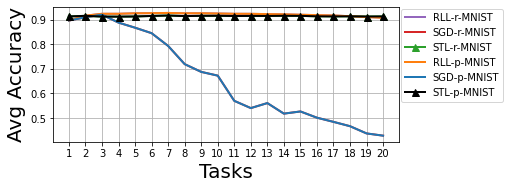

In [26]:
plot_average_accuracy_along_training_path(data_mean, 'mnist_average_accuracy.pdf')

In [42]:
runs = 5
for model in MODELS:
    print(model,data_mean[model]['mean'][0][-1])

SGD-p-MNIST [0.32410001 0.30070001 0.28990001 0.2225     0.2068     0.1854
 0.17       0.1717     0.193      0.213      0.26560001 0.32110001
 0.35170001 0.46090001 0.6393     0.6492     0.7874     0.92329999
 0.94659999 0.94459999]
STL-p-MNIST [0.91309999 0.91799999 0.90629999 0.91169999 0.91559999 0.92589999
 0.92739999 0.89819999 0.92409999 0.91759999 0.90529999 0.91849999
 0.91479999 0.92589999 0.91019999 0.88539999 0.90719999 0.92019999
 0.89679999 0.92099999]
RLL-p-MNIST [0.85729999 0.90729999 0.88689999 0.87659999 0.89709999 0.90989999
 0.90569999 0.89469999 0.90769999 0.91339999 0.90739999 0.91269999
 0.91809999 0.91379999 0.92319999 0.91119999 0.92849999 0.92299999
 0.93159999 0.92849999]
SGD-r-MNIST [0.32410001 0.30070001 0.28990001 0.2225     0.2068     0.1854
 0.17       0.1717     0.193      0.213      0.26560001 0.32110001
 0.35170001 0.46090001 0.6393     0.6492     0.7874     0.92329999
 0.94659999 0.94459999]
RLL-r-MNIST [0.85729999 0.90729999 0.88689999 0.87659999 0.8

In [46]:
np.mean(data_mean['STL-p-MNIST']['mean'][0][-1])

0.9131599923849105